##Midterm Project
In this project, a logistic regression algorithm is implemented and later applied on the dataset collected from UCI database. 

###Dataset Description:
NICEATM and NCCT collected and curated a rat acute oraltoxicity database of systemic toxicity Lethal Dose 50 (LD50)values, which represent the concentration needed to causelethality in 50% of the utilized animals.[4]A total of fivedifferent modelling endpoints related to acute oral systemictoxicity were provided, on the basis of regulatory criteriaand decision contexts used by ICCVAM agencies. In thisstudy, two endpoints were considered to calibrate qualita-tive QSAR models: a) very toxic (VT), defining molecules aspositive (very toxic) if their experimental LD50 was lowerthan  50 mg/kg;  b)  nontoxic  (NT),  defining  moleculespositive (nontoxic) if their experimental LD50was greaterthan or equal to 2,000 mg/kg.

Dataset information is provided in https://archive.ics.uci.edu/ml/datasets/QSAR+oral+toxicity

First of all, Lets open the dataset and show the top 5 entries

In [1]:
import pandas as pd
import numpy as np

link = 'https://raw.githubusercontent.com/tamjidimtiaz/EEE-6002-Privacy_Preserving_Machine_Learning/main/Dataset/qsar_oral_toxicity.csv'

qsar_data = pd.read_csv(link, sep = ';', header = None)

qsar_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,negative
3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative


Let's check how many data points we have.

In [2]:
qsar_data.shape

(8992, 1025)

Let's check that if the dataset contains any null values

In [3]:
qsar_data.isnull().sum()

0       0
1       0
2       0
3       0
4       0
       ..
1020    0
1021    0
1022    0
1023    0
1024    0
Length: 1025, dtype: int64

Let's find the positive and negative class samples and handle them to make a balanced dataset

In [4]:
# find the positive and negative class samples and create a balanced dataset
positive=qsar_data[qsar_data[1024]=='positive']
negative=qsar_data[qsar_data[1024]=='negative'].sample(n=positive.shape[0])
final=pd.concat([positive,negative])

features = final.iloc[:,:-1].values 

# create the target set 
target = final.iloc[:,-1:].values
target[target=='positive'] = 1
target[target=='negative'] = 0

target = target.astype('float')

Create training, validation and testing dataset. The split is considered as 70-10-20

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1) 

Check the amount of samples in each sets

In [6]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

1036
297
149


## Logistic Regression 

Now, logistic regression classifier will be implemented. Let's create a class called LogisticRegression(). First initialize the class object with a variable called max_iter which defines the maximum number of iterations upto which the logistic regression will continue to converge. If a certain criteria is flfilled then the convergance will automatically stop before reaching the max_iter. Then a function sigmoid_activation() is implemented which basically takes a variable and apply the sigmoid activation function on it to get the hypothesis function. Next, model_optimize() function is created to calculate the cost function from the hypothesis function and calculate the gradient of the cost function to operate the gradient descend algorithm. Then, the major operative function fit() is created which basically trace the loss function (both in training and validation), update the weights and continue the operation ntil the cross validation cost decreases. Finally the predict function will take the score and based on the decision boundary it will give a classification label.  

In [7]:
class LogisticRegression(object):
    """
    Logistic Regression Classifier
    """
    def __init__(self, max_iter=8000):
        self.max_iter       = max_iter

    # Sigmoid Function
    def sigmoid_activation(self, result):
        result = result.astype('float')
        final_result = 1/(1+np.exp(-result))
        return final_result
    # Optimizing the model by calculating the cost and gradient
    def model_optimize(self, w, b, X, Y, reg_par):
        m = X.shape[0]
        
        #Prediction
        final_result = self.sigmoid_activation(np.dot(w,X.T)+b)
        Y_T = Y.T
        cost = (-1/m)*(np.sum((Y_T*np.log(final_result)) + ((1-Y_T)*(np.log(1-final_result))))) 
        #
        
        #Gradient calculation
        dw = (1/m)*(np.dot(X.T, (final_result-Y.T).T))-((reg_par*w.T/m))
        db = (1/m)*(np.sum(final_result-Y.T))
        
        grads = {"dw": dw, "db": db}
        
        return grads, cost
    # At each iteration calculate the cost and gradients value, update the weights until the stopping criteria is flfilled     
    def fit(self, w, b, X, Y, X_v , Y_v, learning_rate, no_iterations, reg_par, early_stopping):
        costs = []
        costs_val = []
        cost_val_temp = 10000
        db = []
        normJ = []
        reqit = no_iterations
        for i in range(no_iterations):
            #
            grads, cost = self.model_optimize(w,b,X,Y,reg_par)
            grads_val, cost_val = self.model_optimize(w,b,X_v,Y_v,reg_par)
            #
            dw = grads["dw"]
            normJp=(np.sqrt(np.sum(np.square(dw))))
            db = grads["db"]
            #weight update
            w = w - (learning_rate * (dw.T))
            b = b - (learning_rate * db)
            #
            if (i % 10 == 0):
                normJ.append(normJp)
            if (i % 10 == 0):
                costs_val.append(cost_val)       
            if (i % 10 == 0):
                costs.append(cost)
            # Stopping Criteria
            if (early_stopping == 1):
              if (cost_val < cost_val_temp):
                cost_val_temp = cost_val
                reqit = i
                continue
              else:
                break
            else:
              continue

        #final parameters
        coeff = {"w": w, "b": b}
        gradient = {"dw": dw, "db": db}
        
        return reqit,coeff, normJ, costs, costs_val
    # Predict the Response    
    def predict(self, final_pred, m, threshold):
        y_pred = np.zeros((1,m))
        y_pred[final_pred>threshold] = 1

        return y_pred

##Training and Validation Accuracy

Now the training and validation accuracy is calculated 

In [8]:

from sklearn.metrics import accuracy_score

def weightInitialization(n_features):
        w = np.zeros((1,n_features))
        b = 0
        return w,b

n_features = X_train.shape[1]
print('Number of Features', n_features)
w, b = weightInitialization(n_features)

iter,coeff, gradient, costs, costs_val = LogisticRegression().fit(w, b, X_train, y_train, X_val, y_val, learning_rate=0.01,no_iterations=8000, reg_par = 0.04, early_stopping = 1)
  
#Final prediction
w = coeff["w"]
b = coeff["b"]

print('Optimized weights', w)
print('Optimized intercept',b)


#
final_train_pred = LogisticRegression().sigmoid_activation(np.dot(w,X_train.T)+b)
final_test_pred = LogisticRegression().sigmoid_activation(np.dot(w,X_val.T)+b)
#
m_tr =  X_train.shape[0]
m_ts =  X_val.shape[0]
#
y_tr_pred = LogisticRegression().predict(final_train_pred, m_tr, 0.5)
y_tr_pred = y_tr_pred.T 
print('Training Accuracy',accuracy_score(y_tr_pred, y_train))
#
y_ts_pred = LogisticRegression().predict(final_test_pred, m_ts, 0.5)
y_ts_pred = y_ts_pred.T 
print('Validation Accuracy',accuracy_score(y_ts_pred, y_val))

Number of Features 1024
Optimized weights [[ 0.13128058  0.08167799  0.28963086 ... -0.0352137  -0.19019073
  -0.09419305]]
Optimized intercept 0.007737000741465474
Training Accuracy 0.9121621621621622
Validation Accuracy 0.825503355704698


##Precision & Recall Vs threshold

Precision = TP/(TP+FP)

Recall = TP/(TP+FN)

Here, TP = True Positive  FP = False Positive FN = False Negative

To find this curve, two built in function precision_score and recall_score from scikit learn are imported and at each iteration, these two scores are calculated sing these two functions.

Test Accuracy 0.5824915824915825
Test Accuracy 0.696969696969697
Test Accuracy 0.7306397306397306
Test Accuracy 0.7643097643097643
Test Accuracy 0.7710437710437711
Test Accuracy 0.7710437710437711
Test Accuracy 0.7441077441077442
Test Accuracy 0.696969696969697
Test Accuracy 0.6397306397306397


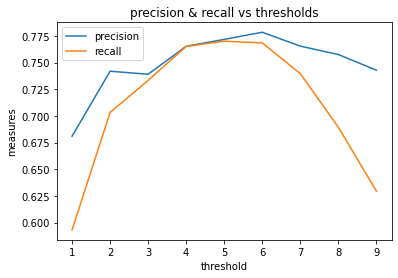

In [9]:
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
%matplotlib inline


thresholds = range(1,10,1)
precisions = []
recalls = []
for i in thresholds:
  final_test_pred = LogisticRegression().sigmoid_activation(np.dot(w,X_test.T)+b)
  m_ts =  X_test.shape[0]
  y_ts_pred = LogisticRegression().predict(final_test_pred, m_ts, i*0.1)
  y_ts_pred = y_ts_pred.T 
  print('Test Accuracy',accuracy_score(y_ts_pred, y_test))
  precisions.append(precision_score(y_test, y_ts_pred, average='macro'))
  recalls.append(recall_score(y_test, y_ts_pred, average='macro'))

plt.plot(thresholds,precisions)
plt.plot(thresholds,recalls)
plt.ylabel('measures')
plt.xlabel('threshold')
plt.title('precision & recall vs thresholds')
plt.legend(["precision", "recall"])

##ROC Curve

ROC curve is the relationship between true positive rate and false positive rate. 

True Positive Rate(TPR) = TP/(TP+FN)

False Positive Rate(FPR) = FP/(FP+TN)




Text(0.5, 1.0, 'ROC CURVE')

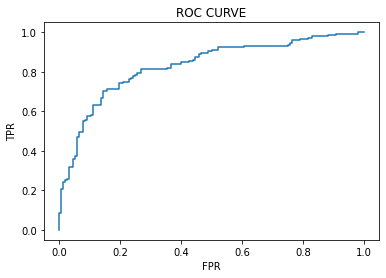

In [10]:
scores = LogisticRegression().sigmoid_activation(np.dot(w,X_test.T)+b)
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores.T, pos_label=1)
plt.plot(fpr,tpr)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC CURVE')

## Cost Vs Iteration

Cost of Training and Validation is calculated in each iteration. Both of thm are decreasing after each iteration.

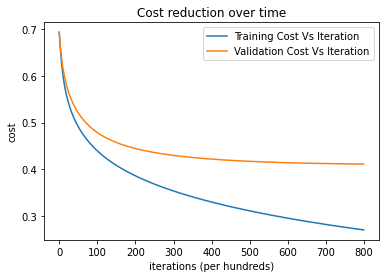

In [11]:

plt.plot(costs)
plt.plot(costs_val)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title('Cost reduction over time')
plt.legend(["Training Cost Vs Iteration", "Validation Cost Vs Iteration"])

## Norm of the gradients vs Iterations

Norm of the gradients in each iterations is calculated. From this crve it is seen the gradient is reduced at each iteration and get closer to zero.

Text(0.5, 1.0, 'Norm of the gradient vs iterations')

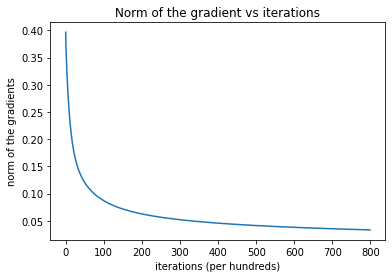

In [12]:

plt.plot(gradient)
plt.ylabel('norm of the gradients')
plt.xlabel('iterations (per hundreds)')
plt.title('Norm of the gradient vs iterations')


## Cost Vs Regularization Parameter

Cost of the training and validation function for different value of regularization parameter is calculated. It is found that training cost is increased with the increment of regularization parameter. and in the validation set it first decreases and then after a certain value it is increasing. This point indicates that for this particular value of regularization parameter the model can avoid overfitting. 

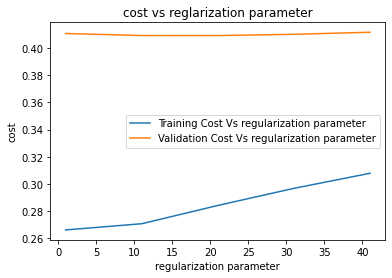

In [13]:


costslam = []
valcostslam = []
j =  [x for x in range(1,50,10)]
for i in j:
  w, b = weightInitialization(n_features)
  iter,coeff, gradient, costs, costs_val = LogisticRegression().fit(w, b, X_train, y_train, X_val, y_val, learning_rate=0.01, no_iterations=8000, reg_par = i, early_stopping = 1)
  costslam.append(costs[-1])
  valcostslam.append(costs_val[-1])
  

plt.plot(j,costslam)
plt.plot(j,valcostslam)
plt.ylabel('cost')
plt.xlabel('regularization parameter')
plt.title('cost vs reglarization parameter')
plt.legend(["Training Cost Vs regularization parameter", "Validation Cost Vs regularization parameter"])


Text(0.5, 1.0, 'validation cost vs reglarization parameter')

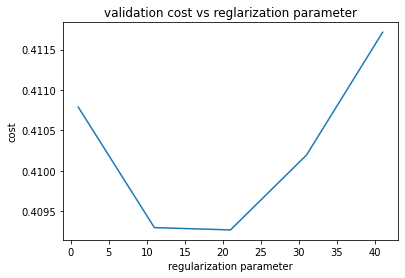

In [14]:

plt.plot(j,valcostslam)
plt.ylabel('cost')
plt.xlabel('regularization parameter')
plt.title('validation cost vs reglarization parameter')


##Required Iterations vs step size

From this curve it is seen that for small value of step size, the model requires many iteration compared to the model with large step size. But at certain point if we continue r=to increase the step size it will not converge. 

Text(0.5, 1.0, 'Reqired Iterations vs step size')

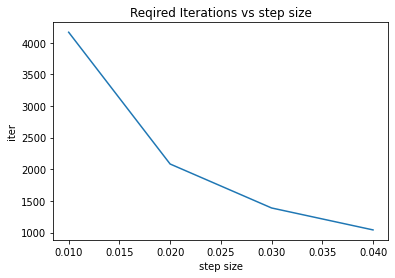

In [15]:

j =  [x*0.01 for x in range(1,5)]
iters = []
for i in j:
  w, b = weightInitialization(n_features)
  iter, coeff, gradient, costs, costs_val = LogisticRegression().fit(w, b, X_train, y_train, X_val, y_val, learning_rate=i, no_iterations=8000, reg_par = 20, early_stopping = 1)  
  iters.append(iter)

plt.plot(j,iters)

plt.ylabel('iter')
plt.xlabel('step size')
plt.title('Reqired Iterations vs step size')



## Cost Vs Sample Size

From this curve it is seen that for small no of training samples, though the training cost is very low, the validation cost is very high. But with the increment of training size the validation lost is reduced which is desired.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


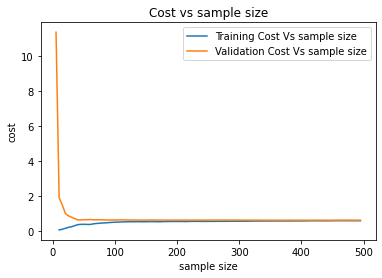

In [16]:
costsam = []
valcostsam = []

j = range(5,500,5)

for i in range(5, 500, 5):
  w, b = weightInitialization(n_features)
  iter, coeff, gradient, costs, costs_val = LogisticRegression().fit(w, b, X_train[1:i,:], y_train[1:i], X_val, y_val, learning_rate=0.01, no_iterations=100, reg_par = 20, early_stopping = 0)  
  costsam.append(costs[-1])
  valcostsam.append(costs_val[-1])

plt.plot(j,costsam)
plt.plot(j,valcostsam)
plt.ylabel('cost')
plt.xlabel('sample size')
plt.title('Cost vs sample size')
plt.legend(["Training Cost Vs sample size", "Validation Cost Vs sample size"])
